## Forecasting Electricity Prices and Retraining Models 📈⚡🔮

This week, I want to try to use two different supervised ML methods on time series data, specifically on Day-Ahead Electricity Prices. The goal is to predict the prices of the day ahead. Then, I want to demonstrate the importance of retraining models frequently by investigating if retraining increases predictive performance.

In [145]:
library(tidyverse)
library(lubridate)
library(doParallel)
library(broom)
library(zoo)
library(lubridate)
library(tidymodels)
library(vip)
library(ggforce)

theme_set(theme_bw() +
    theme(
        plot.title = element_text(face = "bold", size = 14),
        plot.subtitle = element_text(
            face = "italic", size = 10,
            colour = "grey50"
        )
    ))

### The Data

In [146]:
dt <- read_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/09 - Time Series and Retraining/day_ahead.csv")

data <- dt %>% 
  mutate(
    year = year(datetime),
    month = month(datetime),
    dow = wday(datetime, week_start = 1),
    hour = hour(datetime),
    month = lubridate::month(datetime),
    year_half = lubridate::semester(datetime) %>% as.factor,
    week_day = lubridate::wday(datetime),
    week_in_year = lubridate::week(datetime),
    quarter = lubridate::quarter(datetime),
    doy = lubridate::yday(datetime),
    dom = lubridate::mday(datetime),
    date_christmas = ifelse(between(doy, 358, 366), 1, 0)
  )

Rows: 71720 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): price
dttm (1): datetime
date (1): day

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [147]:
data %>% select(datetime) %>% summary()

    datetime                     
 Min.   :2015-01-01 00:00:00.00  
 1st Qu.:2017-01-16 23:45:00.00  
 Median :2019-02-02 23:30:00.00  
 Mean   :2019-02-02 23:43:38.98  
 3rd Qu.:2021-02-18 23:15:00.00  
 Max.   :2023-03-07 23:00:00.00  

In [148]:
glimpse(data)

Rows: 71,720
Columns: 14
$ datetime       <dttm> 2015-01-01 00:00:00, 2015-01-01 01:00:00, 2015-01-01 0…
$ day            <date> 2015-01-01, 2015-01-01, 2015-01-01, 2015-01-01, 2015-0…
$ price          <dbl> 44.94, 43.43, 38.08, 35.47, 30.83, 28.26, 25.36, 26.93,…
$ year           <dbl> 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2…
$ month          <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ dow            <dbl> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4…
$ hour           <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1…
$ year_half      <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ week_day       <dbl> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5…
$ week_in_year   <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ quarter        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ doy            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ dom          

Inspect missing values:

In [149]:
colMeans(is.na(data)) %>%
    enframe() %>%
    arrange(-value) %>%
    filter(value > 0)

name,value
<chr>,<dbl>
price,0.0007808143


Only need to clean the price column:

In [150]:
# Final data cleaning
data <- data %>%
    filter(!is.na(price))

data %>% head()

datetime,day,price,year,month,dow,hour,year_half,week_day,week_in_year,quarter,doy,dom,date_christmas
<dttm>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>
2015-01-01 00:00:00,2015-01-01,44.94,2015,1,4,0,1,5,1,1,1,1,0
2015-01-01 01:00:00,2015-01-01,43.43,2015,1,4,1,1,5,1,1,1,1,0
2015-01-01 02:00:00,2015-01-01,38.08,2015,1,4,2,1,5,1,1,1,1,0
2015-01-01 03:00:00,2015-01-01,35.47,2015,1,4,3,1,5,1,1,1,1,0
2015-01-01 04:00:00,2015-01-01,30.83,2015,1,4,4,1,5,1,1,1,1,0
2015-01-01 05:00:00,2015-01-01,28.26,2015,1,4,5,1,5,1,1,1,1,0


### Exploratory Data Analysis

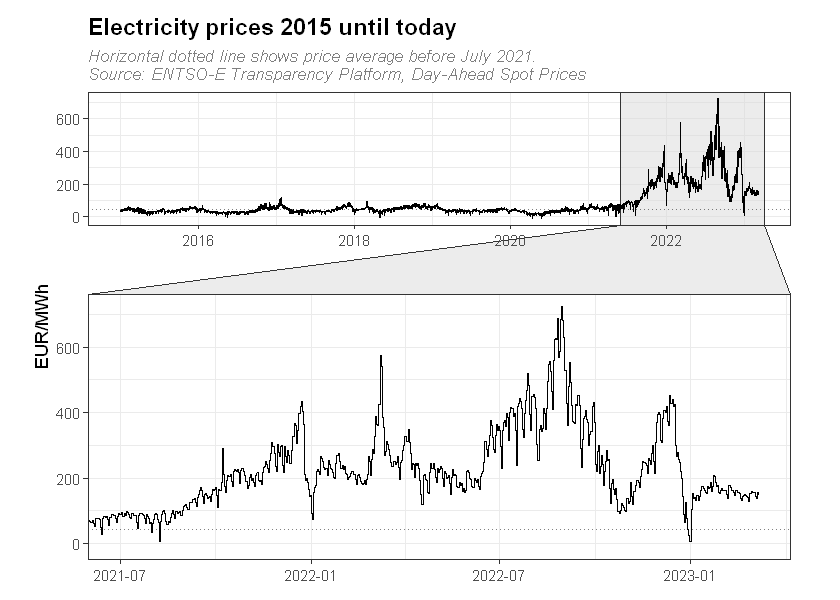

In [295]:
options(repr.plot.width = 7, repr.plot.height = 5)

data %>% 
  group_by(day) %>% 
  summarise(price = mean(price, na.rm = T))  %>% 
  ggplot(aes(day, price)) +
  geom_step(size = 0.4) +
  labs(title = "Electricity prices 2015 until today",
       subtitle = "Horizontal dotted line shows price average before July 2021.\nSource: ENTSO-E Transparency Platform, Day-Ahead Spot Prices",
       y = "EUR/MWh",
       x = NULL) +
  geom_hline(yintercept = mean(dt %>% 
                                 filter(datetime < ymd("2021-07-01")) %>% 
                                 pull(price),
                               na.rm = T),
             lty = "dotted", alpha = 0.5) +
  coord_cartesian(clip="off") +
  expand_limits(y = 0) +
  facet_zoom(x = day >= as.Date("2021-07-01") & day <= as.Date("2023-03-08")) +
  theme(plot.margin = margin(10,30,10,20))

ggsave(width = 6, height = 4, file = "electricity prices.pdf")
ggsave(width = 6, height = 4, dpi = 300, file = "electricity prices.png")

`geom_smooth()` using formula 'y ~ x'



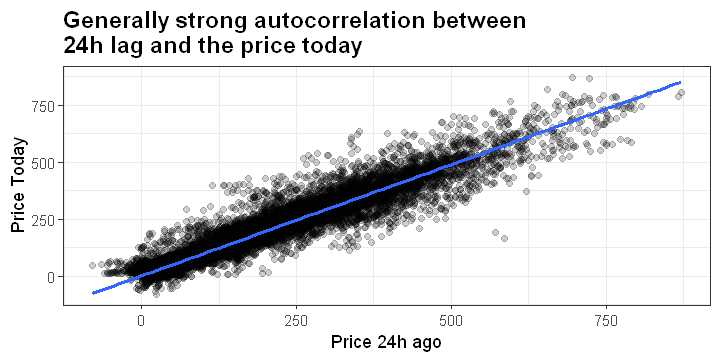

In [291]:
options(repr.plot.width = 6, repr.plot.height = 3)

data %>%
    select(day, price) %>%
    mutate(price_yesterday = lag(price, n = 24)) %>%
    drop_na() %>%
    ggplot(aes(price_yesterday, price)) +
    geom_point(alpha = 0.2) +
    geom_smooth(method = "lm", se = F) +
    labs(
        title = "Generally strong autocorrelation between\n24h lag and the price today",
        y = "Price Today", x = "Price 24h ago"
    )

#### How did that autocorrelation develop over time?

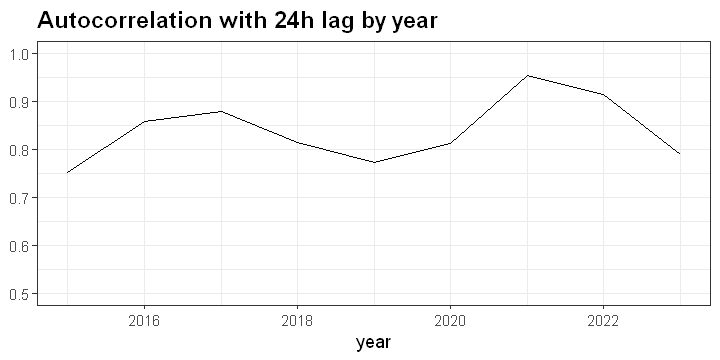

In [292]:
data %>%
    select(day, year, price) %>%
    mutate(price_yesterday = lag(price, n = 24)) %>%
    drop_na() %>%
    group_by(year) %>%
    summarise(lag_corr = cor(price, price_yesterday)) %>%
    ggplot(aes(year, lag_corr)) +
    geom_line() +
    labs(
        title = "Autocorrelation with 24h lag by year",
        y = NULL
    ) +
    scale_y_continuous(limits = c(0.5, 1))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



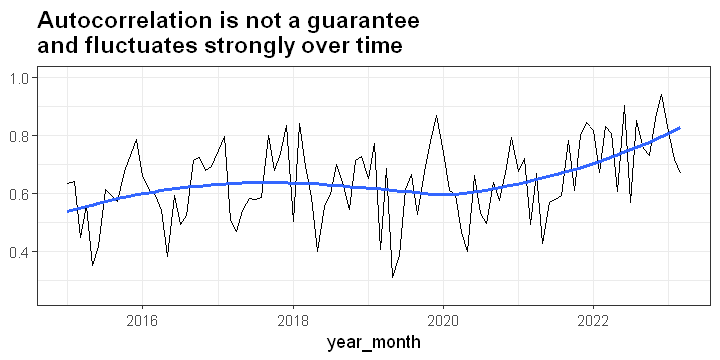

In [293]:
data %>%
    select(day, year, price) %>%
    mutate(
        price_yesterday = lag(price, n = 24),
        year_month = ym(substr(day, 1, 7))
    ) %>%
    drop_na() %>% 
    group_by(year_month) %>%
    summarise(lag_corr = cor(price, price_yesterday)) %>%
    ggplot(aes(year_month, lag_corr)) +
    geom_line() +
    labs(
        title = "Autocorrelation is not a guarantee\nand fluctuates strongly over time",
        y = NULL
    ) +
    geom_smooth(se = F) +
    scale_y_continuous(limits = c(0.25, 1))

Is there autocorrelation in the correlation???

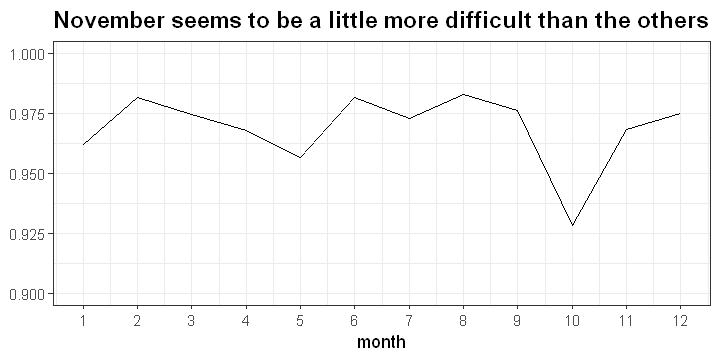

In [294]:
data %>%
    select(day, month, price) %>%
    mutate(price_yesterday = lag(price, n = 24)) %>%
    drop_na() %>% 
    group_by(month) %>%
    summarise(lag_corr = cor(price, price_yesterday)) %>%
    ggplot(aes(month, lag_corr)) +
    geom_line() +
    labs(
        title = "November seems to be a little more difficult than the others",
        y = NULL
    ) +
    scale_y_continuous(limits = c(0.9, 1)) +
    scale_x_continuous(breaks = 1:12)

### Building Models without Retraining

In [156]:
# Include lags for autocorrelation
for (i in 25:48){
  var_name <- paste0("price_lag", i)
  data[,var_name] <- lag(data$price, i)
}

In [161]:
dt_train <- data %>% 
  filter(year < 2022)

dt_test <- data %>% 
  filter(year >= 2022)

In [162]:
dt_train$day %>% min() %>% print()
dt_train$day %>% max() %>% print()

[1] "2015-01-01"
[1] "2021-12-31"


In [163]:
dt_test$day %>% min() %>% print()
dt_test$day %>% max() %>% print()

[1] "2022-01-01"
[1] "2023-03-07"


Different recipes for elastic net and random forest, as elastic net cannot deal with factors:

In [172]:
rf_rec <- recipe(price ~ ., data = dt_train) %>%
  step_date(datetime) %>% 
  step_holiday(datetime, holidays = timeDate::listHolidays("CH")) %>%
  step_impute_mean(all_numeric_predictors()) %>% 
  step_rm(datetime, day)

rf_rec %>% prep() %>% bake(dt_test) %>% glimpse()

Rows: 10,344
Columns: 44
$ year                        <dbl> 2022, 2022, 2022, 2022, 2022, 2022, 2022, …
$ month                       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ dow                         <dbl> 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, …
$ hour                        <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …
$ year_half                   <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ week_day                    <dbl> 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, …
$ week_in_year                <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ quarter                     <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ doy                         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ dom                         <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ date_christmas              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ price_lag25                 <dbl> 137.04, 134.34, 124.85, 115.12, 115.52, 11…
$ price_lag26  

In [173]:
en_rec <- recipe(price ~ ., data = dt_train) %>%
  step_naomit(price) %>% 
  step_date(datetime) %>% 
  step_holiday(datetime, holidays = timeDate::listHolidays("CH")) %>%
  step_rm(datetime) %>% 
  step_impute_mean(all_numeric_predictors()) %>% 
  step_normalize(all_numeric_predictors()) %>% 
  step_dummy(all_nominal_predictors()) %>% 
  step_zv(all_predictors()) %>% 
  step_rm(day)

en_rec %>% prep() %>% bake(dt_test) %>% glimpse()

Rows: 10,344
Columns: 59
$ year                        <dbl> 1.999397, 1.999397, 1.999397, 1.999397, 1.…
$ month                       <dbl> -1.602181, -1.602181, -1.602181, -1.602181…
$ dow                         <dbl> 0.9994545, 0.9994545, 0.9994545, 0.9994545…
$ hour                        <dbl> -1.66131123, -1.51684938, -1.37238753, -1.…
$ week_day                    <dbl> 1.498839, 1.498839, 1.498839, 1.498839, 1.…
$ week_in_year                <dbl> -1.699717, -1.699717, -1.699717, -1.699717…
$ quarter                     <dbl> -1.350916, -1.350916, -1.350916, -1.350916…
$ doy                         <dbl> -1.728071, -1.728071, -1.728071, -1.728071…
$ dom                         <dbl> -1.673386, -1.673386, -1.673386, -1.673386…
$ date_christmas              <dbl> -0.1524057, -0.1524057, -0.1524057, -0.152…
$ price_lag25                 <dbl> 1.947079, 1.885072, 1.667130, 1.443676, 1.…
$ price_lag26                 <dbl> 2.414581, 1.947211, 1.885201, 1.667248, 1.…
$ price_lag27  

Fitting the models once, without retraining:

In [168]:
rf_fit <- workflow() %>% 
  add_recipe(rf_rec) %>% 
  add_model(rand_forest() %>% 
              set_mode("regression") %>% 
              set_engine("ranger", importance = "permutation")) %>% 
  fit(dt_train)

In [169]:
en_fit <- workflow() %>% 
  add_recipe(en_rec) %>% 
  add_model(linear_reg(mixture = 0.5, penalty = 0.02) %>% 
              set_mode("regression") %>% 
              set_engine("glmnet", importance = "permutation")) %>% 
  fit(dt_train)

Write the predictions to `.csv` for later use:

In [204]:
rf_fit %>% 
    augment(data %>% filter(year >= 2022)) %>% 
    write_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/09 - Time Series and Retraining/Predictions/preds_rf_no_retrain.csv")

In [205]:
en_fit %>% 
    augment(data %>% filter(year >= 2022)) %>% 
    write_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/09 - Time Series and Retraining/Predictions/preds_en_no_retrain.csv")

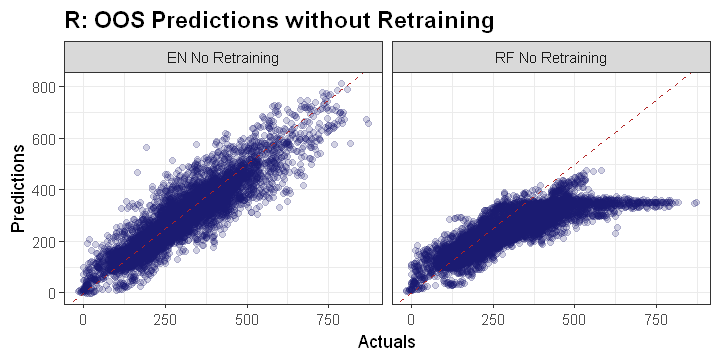

In [206]:
options(repr.plot.width = 6, repr.plot.height = 3)

bind_rows(
    rf_fit %>%
        augment(dt_test) %>%
        transmute(price, .pred, model = "RF No Retraining"),
    en_fit %>%
        augment(dt_test) %>%
        transmute(price, .pred, model = "EN No Retraining")
) %>%
    ggplot(aes(price, .pred)) +
    geom_point(alpha = 0.2, colour = "midnightblue") +
    labs(
        title = "R: OOS Predictions without Retraining",
        y = "Predictions", x = "Actuals"
    ) +
    geom_abline(colour = "firebrick", lty = "dashed") +
    facet_wrap(~model)

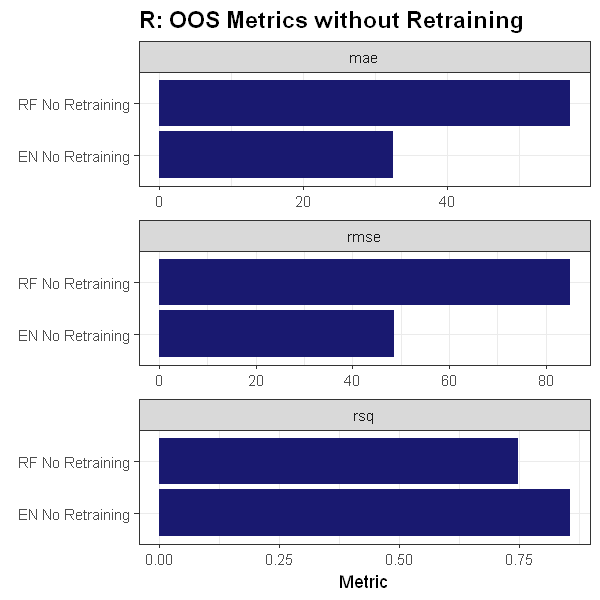

In [207]:
eval_metrics <- metric_set(rsq, mae, rmse)

options(repr.plot.width = 5, repr.plot.height = 5)

bind_rows(
  rf_fit %>%
    augment(dt_test) %>%
    transmute(price, .pred, model = "RF No Retraining"),
  en_fit %>%
    augment(dt_test) %>%
    transmute(price, .pred, model = "EN No Retraining")
) %>%
  group_by(model) %>%
  eval_metrics(truth = price, estimate = .pred) %>%
  ggplot(aes(y = model, .estimate)) +
  geom_col(fill = "midnightblue") +
  facet_wrap(~ .metric, scales = "free", ncol = 1) +
  labs(
    title = "R: OOS Metrics without Retraining",
    x = "Metric", y = NULL
  )

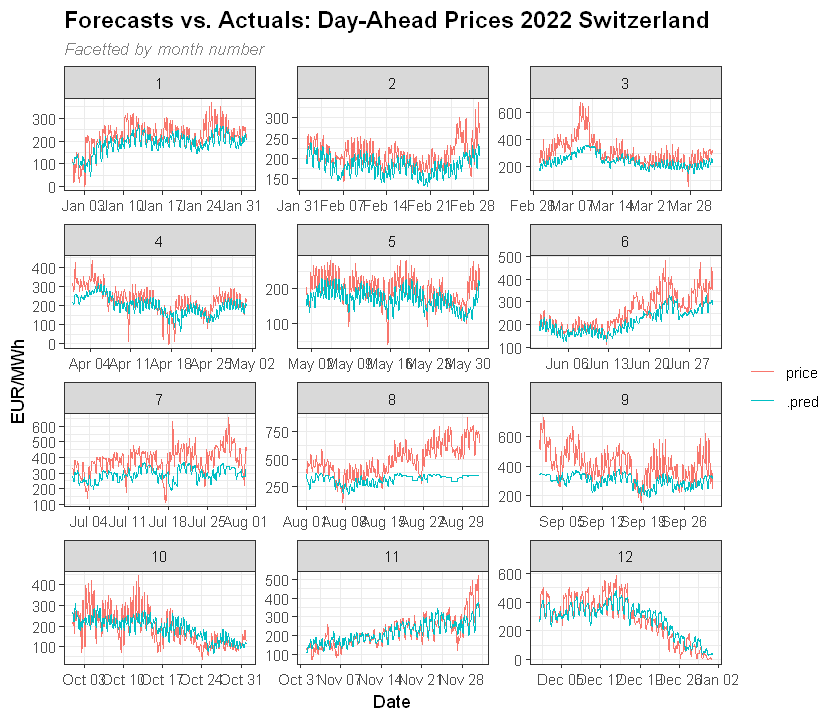

In [209]:
options(repr.plot.width = 7, repr.plot.height = 6)

rf_fit %>% 
  augment(data %>% filter(year == 2022)) %>% 
  select(datetime, price, .pred, month) %>% 
  pivot_longer(-c(datetime, month)) %>% 
  ggplot(aes(datetime, value, colour = fct_rev(name))) +
  geom_line(size = 0.5) +
  labs(title = "Forecasts vs. Actuals: Day-Ahead Prices 2022 Switzerland",
       subtitle = "Facetted by month number",
       y = "EUR/MWh",
       x = "Date",
       colour = NULL) +
  facet_wrap(~ month, scales = "free", ncol = 3) +
  scale_y_continuous(labels = comma_format())

### Building Models with Retraining

The actual code is in the R scripts, because writing it in the notebook is quite cumbersome.

### Comparing Performance with and without Retraining

In [210]:
# Elastic Nets
preds_en_no_retrain <- read_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/09 - Time Series and Retraining/Predictions/preds_en_no_retrain.csv")
preds_en_retrain <- read_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/09 - Time Series and Retraining/Predictions/preds_en_retrain1.csv")

# Random Forests
preds_rf_no_retrain <- read_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/09 - Time Series and Retraining/Predictions/preds_rf_no_retrain.csv")
preds_rf_retrain <- read_csv("C:/Users/mathi/OneDrive/Python/52-Weeks-of-Python-and-R-2023/09 - Time Series and Retraining/Predictions/preds_rf_retrain1.csv")

Rows: 10344 Columns: 39
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (37): price, year, month, dow, hour, year_half, week_day, week_in_year,...
dttm  (1): datetime
date  (1): day

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10345 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (37): day, price, year, month, hour, year_half, week_day, week_in_year,...
dttm  (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10344 Columns: 39
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (37): price, year, month, dow, hour, year_half, week_day, week_in_year,...
dttm  (1): datetime
date  (1): day


Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."


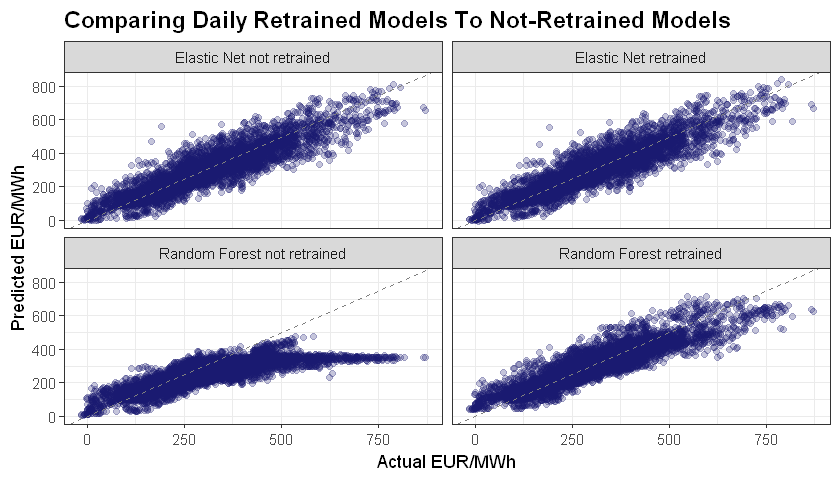

In [299]:
options(repr.plot.width = 7, repr.plot.height = 4)

bind_rows(
  preds_en_retrain %>%
    select(.pred, price) %>%
    mutate(id = "Elastic Net retrained"),
  preds_en_no_retrain %>%
    select(.pred, price) %>%
    mutate(id = "Elastic Net not retrained"),
  preds_rf_no_retrain %>%
    select(.pred, price) %>%
    mutate(id = "Random Forest not retrained"),
  preds_rf_retrain %>%
    select(.pred, price) %>%
    mutate(id = "Random Forest retrained")
) %>%
  ggplot(aes(price, .pred)) +
  geom_point(alpha = 0.25, colour = "midnightblue") +
  geom_abline(colour = "grey50", lty = "dashed") +
  facet_wrap(~id) +
  labs(
    title = "Comparing Daily Retrained Models To Not-Retrained Models",
    x = "Actual EUR/MWh",
    y = "Predicted EUR/MWh"
  )

ggsave(width = 7, height = 4, filename = "Preds_v_Actuals.pdf")
ggsave(width = 7, height = 4, filename = "Preds_v_Actuals.png", dpi = 300)

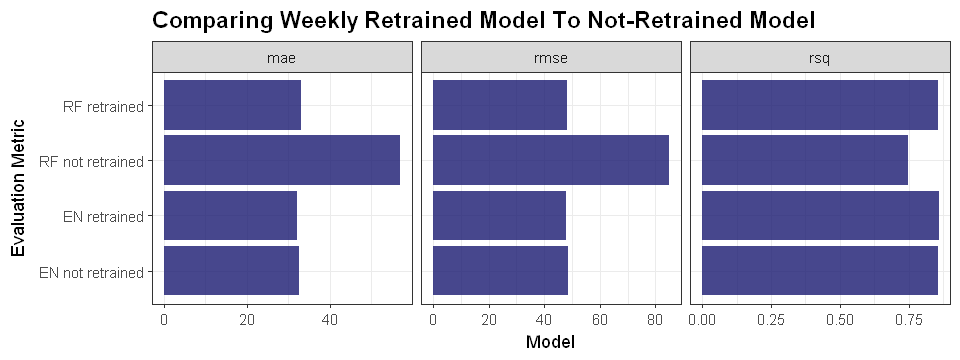

In [213]:
options(repr.plot.width = 8, repr.plot.height = 3)

bind_rows(
  preds_en_retrain %>%
    select(.pred, price) %>%
    mutate(id = "EN retrained"),
  preds_en_no_retrain %>%
    select(.pred, price) %>%
    mutate(id = "EN not retrained"),
  preds_rf_no_retrain %>%
    select(.pred, price) %>%
    mutate(id = "RF not retrained"),
  preds_rf_retrain %>%
    select(.pred, price) %>%
    mutate(id = "RF retrained")
) %>%
    group_by(id) %>%
    eval_metrics(truth = price, estimate = .pred) %>%
    ggplot(aes(y = id, .estimate)) +
    geom_col(fill = "midnightblue", alpha = 0.8) +
    facet_wrap(~.metric, scales = "free_x") +
    labs(
        title = "Comparing Weekly Retrained Model To Not-Retrained Model",
        y = "Evaluation Metric",
        x = "Model"
    )

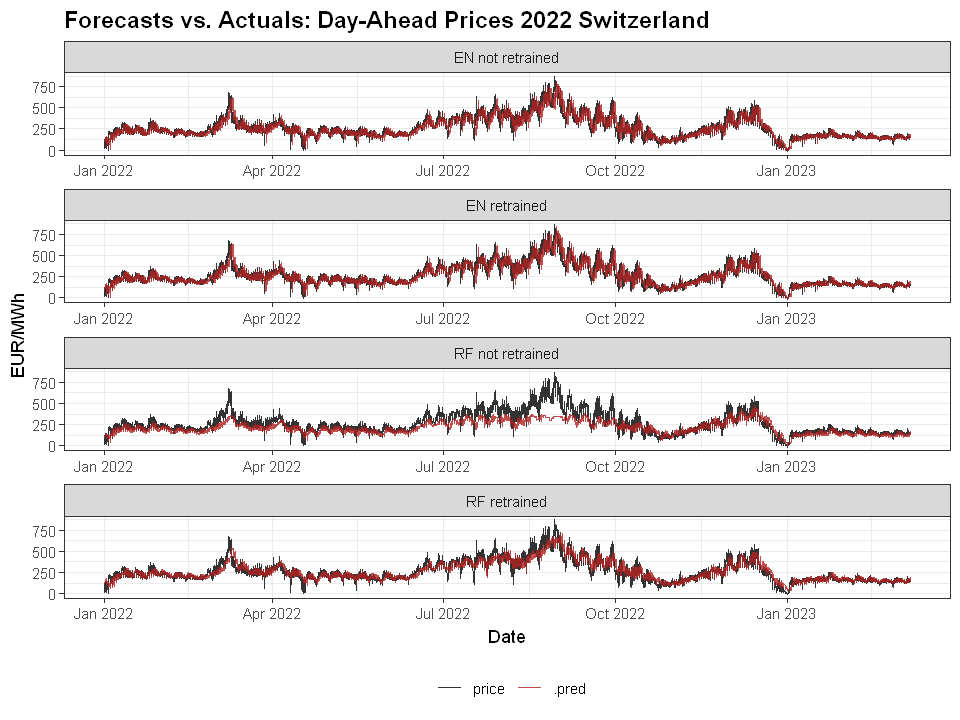

In [214]:
options(repr.plot.width = 8, repr.plot.height = 6)

bind_rows(
  preds_en_retrain %>%
    select(datetime, month, .pred, price) %>%
    mutate(id = "EN retrained"),
  preds_en_no_retrain %>%
    select(datetime, month, .pred, price) %>%
    mutate(id = "EN not retrained"),
  preds_rf_no_retrain %>%
    select(datetime, month, .pred, price) %>%
    mutate(id = "RF not retrained"),
  preds_rf_retrain %>%
    select(datetime, month, .pred, price) %>%
    mutate(id = "RF retrained")
) %>%
    # Look more closely at a shorter period
  # filter(ymd(substr(datetime, 1, 10)) > ymd("2022-01-01"),
  #        ymd(substr(datetime, 1, 10)) < ymd("2022-02-01")) %>% 
  pivot_longer(-c(datetime, id, month)) %>% 
  ggplot(aes(datetime, value, colour = fct_rev(name))) +
  geom_line(size = 0.25, alpha = 0.8) +
  labs(title = "Forecasts vs. Actuals: Day-Ahead Prices 2022 Switzerland",
       y = "EUR/MWh",
       x = "Date",
       colour = NULL) +
  facet_wrap(~ id, scales = "free", ncol = 1) +
  scale_y_continuous(labels = comma_format()) +
  scale_colour_manual(values = c("black", "firebrick")) +
  theme(legend.position = "bottom")

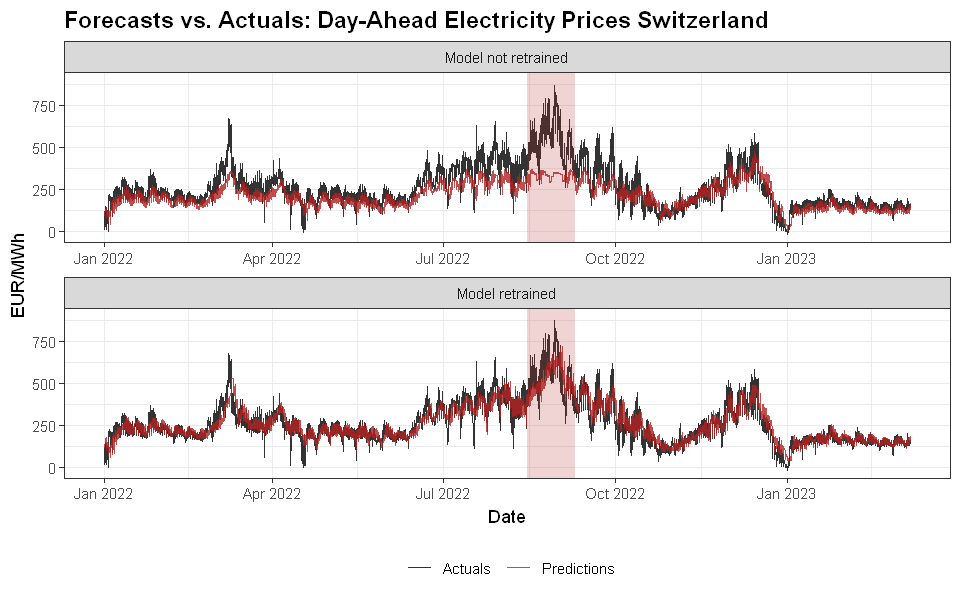

In [296]:
options(repr.plot.width = 8, repr.plot.height = 5)

bind_rows(
    preds_rf_no_retrain %>%
        transmute(datetime, month, Predictions = .pred, Actuals = price) %>%
        mutate(id = "Model not retrained"),
    preds_rf_retrain %>%
        transmute(datetime, month, Predictions = .pred, Actuals = price) %>%
        mutate(id = "Model retrained")
) %>%
    # Look more closely at a shorter period
    # filter(ymd(substr(datetime, 1, 10)) > ymd("2022-01-01"),
    #        ymd(substr(datetime, 1, 10)) < ymd("2022-02-01")) %>%
    pivot_longer(-c(datetime, id, month)) %>% 
    ggplot(aes(datetime, value, colour = name)) +
    geom_line(size = 0.25, alpha = 0.8) +
    labs(
        title = "Forecasts vs. Actuals: Day-Ahead Electricity Prices Switzerland",
        y = "EUR/MWh",
        x = "Date",
        colour = NULL
    ) +
    annotate("rect",
        xmin = ymd_hm("2022-08-15 00:00"), xmax = ymd_hm("2022-09-10 00:00"),
        ymin = -100, ymax = 1000, alpha = 0.2, fill = "firebrick"
    ) +
    facet_wrap(~id, scales = "free", ncol = 1) +
    scale_y_continuous(labels = comma_format()) +
    coord_cartesian(ylim = c(-20, 900)) +
    scale_colour_manual(values = c("black", "firebrick")) +
    theme(legend.position = "bottom")

ggsave(width = 8, height = 5, file = "RF_retraining_time series.pdf")
ggsave(width = 8, height = 5, dpi = 300, file = "RF_retraining_time series.png")

### Conclusion

The Elastic Net didn't benefit from retraining, but the random forest did greatly benefit! Generally, elastic net seems to stick more strongly to the autocorrelation component than the random forest does. The retrained random forest seems to be the best solution, but I'm sure that this model can be expaned further (more variables, more data, longer lookback than 3 years). As the point of this week was only to show the benefit of retraining, I won't dive deeper into increasing model performance and conclude with the images shown.